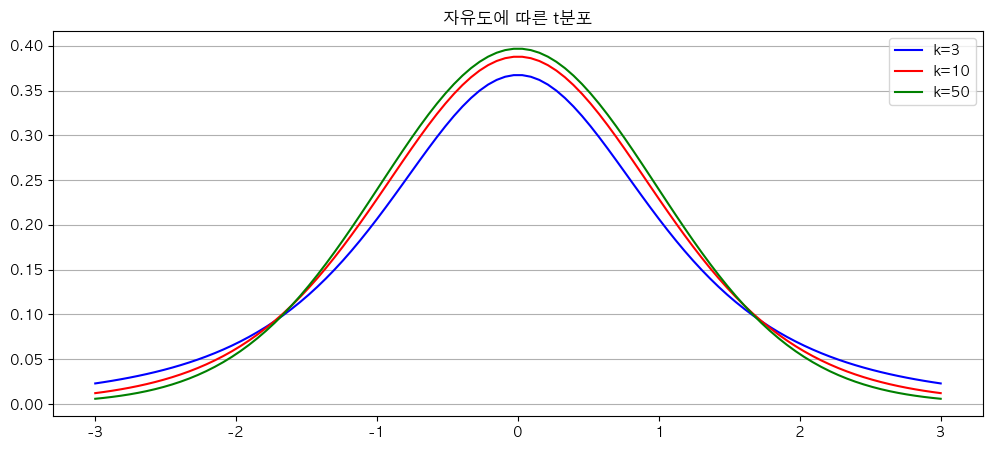

In [1]:
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sb
from numpy import linspace

plt.rcParams["font.family"]="Applegothic"
plt.rcParams["axes.unicode_minus"]=False
x=linspace(-3,3,100)
y_1=st.t.pdf(x,3)
y_2=st.t.pdf(x,9)
y_3=st.t.pdf(x,50)


plt.figure(figsize=(12,5))
plt.title("자유도에 따른 t분포")
sb.lineplot(x=x,y=y_1,label="k=3",color="blue")
sb.lineplot(x=x,y=y_2,label="k=10",color="red")
sb.lineplot(x=x,y=y_3,label="k=50",color="green")

plt.grid(axis="y")

In [2]:
from sklearn import linear_model as lin
from sklearn import model_selection as mod
from sklearn import pipeline as pip
from sklearn import compose as com
from sklearn import impute as imp
from sklearn import preprocessing as pre
from sklearn import metrics as met
import numpy as np
import pandas as pd

titanic=pd.read_csv("../titanic/train.csv")
titanic.head(3)

titanic_df=titanic.drop(columns=["PassengerId","Name","Ticket","Cabin"])
obj_col=titanic_df.dropna().select_dtypes("object").columns
num_col=titanic_df.dropna().select_dtypes(np.number).columns.difference(["Survived"])
label="Survived"

columns=titanic_df.columns.difference([label])

num_pip=pip.make_pipeline(imp.SimpleImputer(strategy="mean"),pre.StandardScaler())
obj_pip=pip.make_pipeline(imp.SimpleImputer(strategy="most_frequent"),pre.OneHotEncoder(drop="first",handle_unknown="ignore"))

total_pip=com.make_column_transformer((num_pip,num_col),(obj_pip,obj_col),remainder="passthrough")

model=pip.make_pipeline(total_pip,lin.LogisticRegression())

random_states=range(10)

kfolds_splits=[]
for i in random_states:
    kfolds=mod.StratifiedKFold(n_splits=10,shuffle=True,random_state=i)
    split_=[split for split in kfolds.split(X=titanic[columns],y=titanic[label])]
    kfolds_splits.append(split_)

def folds_train(model,folds):
    result=[]
    for fold in folds:
        train=titanic.loc[fold[0]]
        test=titanic.loc[fold[1]]

        model.fit(X=train[columns],y=train[label])
        proba_=model.predict_proba(X=test[columns])

        score=met.roc_auc_score(y_true=test[label],y_score=proba_[:,1])
        result.append(score)
    return result

total=np.array([folds_train(model,kfold) for kfold in kfolds_splits])

In [3]:
from matplotlib import pyplot as plt
from scipy import optimize as opt
from functools import partial

mu=total.mean()
sigma=total.std()
k=len(total.ravel())-1

t_stats=k**(1/2)*(mu-0.9)/(sigma)
print("t_stats :",t_stats)
print("mu :",mu)

t_stats : -10.969569132696794
mu : 0.8522375774552243


In [4]:
from scipy import stats as st
from scipy import optimize as opt
from functools import partial

def max_min_tstats(popmean:float,a,stratigy):
    return st.ttest_1samp(a=a,popmean=popmean,alternative=stratigy).pvalue-0.05

two_side=partial(max_min_tstats,a=total.ravel(),stratigy='two-sided')

if opt.root_scalar(two_side,bracket=[0,mu]).converged:
    min_tstats=opt.root_scalar(two_side,bracket=[0,mu]).root

if opt.root_scalar(two_side,bracket=[mu,1]).converged:
    max_tstats=opt.root_scalar(two_side,bracket=[mu,1]).root

t_stats : -10.969569132696794


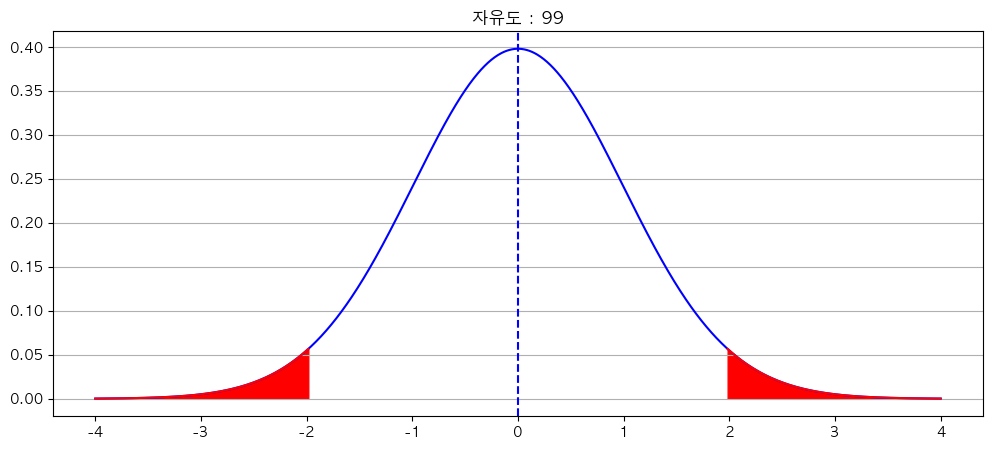

In [5]:
from matplotlib import pyplot as plt
from scipy import optimize as opt
from functools import partial

mu=total.mean()
sigma=total.std()
k=len(total.ravel())-1

t_stats=k**(1/2)*(mu-0.9)/(sigma)
print("t_stats :",t_stats)

X_range=np.linspace(-4,4,1000)
pdf_=st.t.pdf(X_range,df=k)

def max_min_tstats(popmean:float,a,stratigy):
    return st.ttest_1samp(a=a,popmean=popmean,alternative=stratigy).pvalue-0.05

two_side=partial(max_min_tstats,a=total.ravel(),stratigy='two-sided')

if opt.root_scalar(two_side,bracket=[0,mu]).converged:
    min_popmean=opt.root_scalar(two_side,bracket=[0,mu]).root

if opt.root_scalar(two_side,bracket=[mu,1]).converged:
    max_popmean=opt.root_scalar(two_side,bracket=[mu,1]).root

max_t_stats=k**(1/2)*(mu-min_popmean)/(sigma)
min_t_stats=k**(1/2)*(mu-max_popmean)/(sigma)

min_X_range=np.linspace(-4,min_t_stats,100)
max_X_range=np.linspace(max_t_stats,4,100)

min_pdf_=st.t.pdf(min_X_range,df=k)
max_pdf_=st.t.pdf(max_X_range,df=k)

plt.figure(figsize=(12,5))
plt.title(f"자유도 : {k}")
plt.plot(X_range,pdf_,color="blue")
plt.plot(min_X_range,min_pdf_,color="red")
plt.plot(max_X_range,max_pdf_,color="red")
# plt.axvline(x=t_stats,color="red",linestyle="--",label="epsilon=0.9")
plt.axvline(x=0,color="blue",linestyle="--")
plt.fill_between(x=min_X_range,y1=min_pdf_,y2=0,color="red")
plt.fill_between(x=max_X_range,y1=max_pdf_,y2=0,color="red")
# plt.legend()
plt.grid(axis="y")

In [6]:
print("신뢰도 95% 에서의 일반 성능척도 :",[min_popmean,max_popmean])

신뢰도 95% 에서의 일반 성능척도 : [0.8435981306988614, 0.8608770242115897]


In [7]:
from sklearn import svm
from copy import deepcopy

logit=deepcopy(model)
svc=pip.make_pipeline(model.named_steps["columntransformer"],svm.SVC())

kfolds_splits=[]

First_split=mod.StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
kfolds_split=mod.StratifiedKFold(n_splits=2,shuffle=True,random_state=1)
split_=[split[1] for split in First_split.split(X=titanic[columns],y=titanic[label])]

kfolds_splited=[]
for split in split_:
    split_titanic=titanic.loc[split]
    kfolds_splited.append([splited for splited in kfolds_split.split(X=split_titanic[columns],y=split_titanic[label])])

def folds_train(model,folds):
    result=[]
    for fold in folds:
        train=titanic.loc[fold[0]]
        test=titanic.loc[fold[1]]

        model.fit(X=train[columns],y=train[label])
        pred_y=model.predict(X=test[columns])

        score=met.accuracy_score(y_true=test[label],y_pred=pred_y)
        result.append(score)
    return result

In [8]:
total_logit=np.array([folds_train(logit,kfold) for kfold in kfolds_splited])
total_svc=np.array([folds_train(svc,kfold) for kfold in kfolds_splited])
kfold_grad=total_logit-total_svc
kfold_mu=(kfold_grad).mean(axis=1)
kfold_var=(kfold_grad).var(axis=1)
stats=(kfold_mu[0])/(kfold_var.mean()**(1/2))
print("검정통계량 :",stats)

검정통계량 : 0.46444076353163855


|임계값| :  2.570581835636316


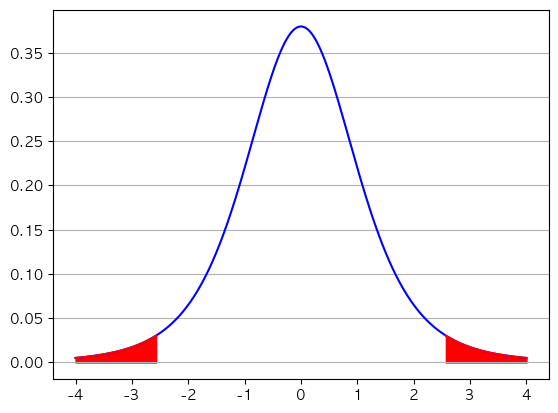

In [9]:
x_range=np.linspace(-4,4,1000)
y=st.t.pdf(x_range,5)

def func_(stats):
    return st.t.sf(stats,5)-0.025

if opt.root_scalar(func_,bracket=[0,4]).converged:
    root=opt.root_scalar(func_,bracket=[0,4]).root

min_x_range=np.linspace(-4,-root,100)
max_x_range=np.linspace(root,4,100)
min_y=st.t.pdf(min_x_range,5)
max_y=st.t.pdf(max_x_range,5)

print("|임계값| : ",root)

plt.plot(x_range,y,color="blue")
plt.plot(min_x_range,min_y,color="red")
plt.plot(max_x_range,max_y,color="red")
plt.fill_between(min_x_range,y1=min_y,y2=0,color="red")
plt.fill_between(max_x_range,y1=max_y,y2=0,color="red")
plt.grid(axis="y")

In [10]:
from mlxtend.evaluate import paired_ttest_5x2cv

In [11]:
from mlxtend.evaluate import paired_ttest_5x2cv
stats,pvalue=paired_ttest_5x2cv(logit,svc,titanic[columns],titanic[label],random_seed=1,scoring="accuracy")

print("검정통계량 :",stats)
print("pvalue :",pvalue)

검정통계량 : -2.589166429210764
pvalue : 0.04888617315159634


In [12]:
from matplotlib import pyplot
from scipy import stats as st
from scipy import optimize as opt
from numpy import linspace

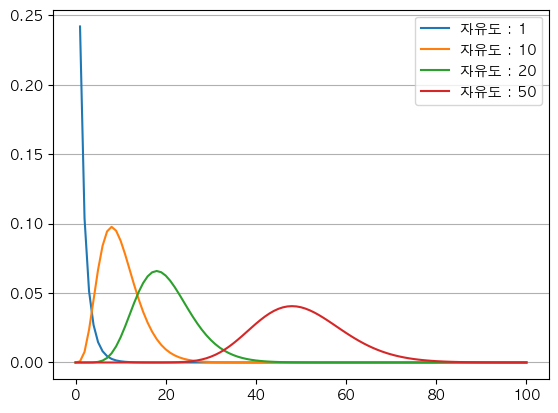

In [13]:
x_range=linspace(0,100,101)
y_=[]
for df in [1,10,20,50]:
    y_.append(st.chi2.pdf(x_range,df))

plt.figure()
for y,label in zip(y_,[1,10,20,50]):
    plt.plot(x_range,y,label=f"자유도 : {label}")
plt.legend()
plt.grid(axis="y")

In [14]:
def folds_train(model,folds):
    result={x:[] for x in ["label","pred"]}
    for fold in folds:
        train=titanic.loc[fold[0]]
        test=titanic.loc[fold[1]]

        model.fit(X=train[columns],y=train[label])
        pred_y=model.predict(X=test[columns])

        result["label"].extend(test[label].values)
        result["pred"].extend(pred_y)
        
    return result

logit_=[folds_train(logit,kfold) for kfold in kfolds_splited]
svc_=[folds_train(svc,kfold) for kfold in kfolds_splited]

KeyError: 50

In [ ]:
contin_={x:[] for x in ['y_true',"pred_log","pred_svc"]}
for log,svc in zip(logit_,svc_):
    contin_["y_true"].extend(log["label"])
    contin_["pred_log"].extend(log["pred"])
    contin_["pred_svc"].extend(svc["pred"])

In [ ]:
matrix=np.array([[0,0],[0,0]])
for y_,pred_log,pred_svc in zip(*contin_.values()):
    check_=np.array([0,0])
    if y_!=pred_log:
        check_+=np.array([0,1])
    if y_!=pred_svc:
        check_+=np.array([1,0])
    matrix[list(check_)]+=1

In [ ]:
matrix

array([[739, 739],
       [229, 229]])

In [ ]:
loocv=mod.KFold(n_splits=len(titanic))

test_result={x:list() for x in ["label","pred_logit","pred_svc"]}
for x,y in loocv.split(X=titanic[columns],y=titanic[label]):
    train_=titanic.loc[x]
    test_=titanic.loc[y]

    logit.fit(X=train_[columns],y=train_[label])
    svc.fit(X=train_[columns],y=train_[label])

    test_result["label"].append(test_[label].values)
    test_result["pred_logit"].append(logit.predict(test_[columns]))
    test_result["pred_svc"].append(svc.predict(test_[columns]))

In [ ]:
contingency_tables=np.array([[0,0],[0,0]])
for i in range(len(test_result["label"])):
    posi=np.array([0,0])
    if test_result["label"][i]!=test_result["pred_logit"][i]:
        posi+=np.array([1,0])
    if test_result["label"][i]!=test_result["pred_svc"][i]:
        posi+=np.array([0,1])
    contingency_tables[list(posi)]+=1

print("분할표 \n",contingency_tables)

분할표 
 [[753 753]
 [199 199]]


In [ ]:
contingency_tables

array([[753, 753],
       [199, 199]])

In [ ]:
from statsmodels.stats.contingency_tables import mcnemar

result=mcnemar(table=contingency_tables,exact=False)
print("검정 통계량 :",result.statistic) 
print("pvalue :",result.pvalue)

검정 통계량 : 321.2279411764706
pvalue : 7.824032448902415e-72


In [ ]:
from scipy import stats as st

mcne_stats=(abs(contingency_tables[1,0]-contingency_tables[0,1])-1)**(2)/((contingency_tables[1,0]+contingency_tables[0,1]))
print("직접구한 검정통계량 :",mcne_stats)
#st.chi2.sf(mcne_stats,df=1)

직접구한 검정통계량 : 321.2279411764706


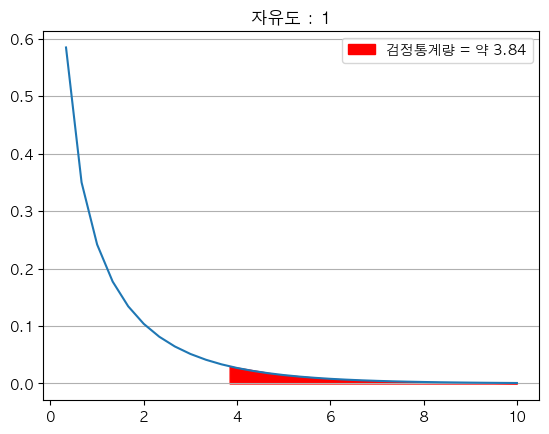

In [ ]:
from scipy import stats as st
from scipy import optimize as opt

def optimize_(stats):
    return st.chi2.sf(stats,df=1)-0.05

if opt.root_scalar(optimize_,bracket=[0,100]).converged:
    root_stats=opt.root_scalar(optimize_,bracket=[0,100]).root

x_range=linspace(0,10,31)
y=st.chi2.pdf(x_range,1)

root_stats_range=linspace(root_stats,10,(10-int(root_stats)))
root_y_space=st.chi2.pdf(root_stats_range,1)

plt.figure()
plt.title("자유도 : 1")
plt.plot(x_range,y)
plt.fill_between(x=root_stats_range,y1=root_y_space,y2=0,color="red",label=f"검정통계량 = 약 {round(root_stats,2)}")
plt.legend()
plt.grid(axis="y")